In [1]:
from typing import Callable

import torch
from torch.utils.data import Dataset
from numpy.typing import NDArray
import matplotlib.pyplot as plt

from careamics.lvae_training.dataset import DatasetConfig, DataSplitType, DataType
from careamics.lvae_training.dataset import LCMultiChDloader, MultiChDloader

from examples.bioSR.load_data_mrc import get_train_val_data

In [2]:
def get_data_configs() -> tuple[DatasetConfig, DatasetConfig]:
    padding_kwargs = {"mode": "reflect"}
    
    train_data_config = DatasetConfig(
        datasplit_type=DataSplitType.Train,
        image_size=64,
        num_channels=2,
        multiscale_lowres_count=1,
        data_type=DataType.BioSR_MRC,
        ch1_fname="ER/GT_all.mrc",
        ch2_fname="CCPs/GT_all.mrc",
        enable_gaussian_noise=True,
        synthetic_gaussian_scale=5100,
        input_has_dependant_noise=True,
        enable_random_cropping=True,
        allow_generation=True,
        padding_kwargs=padding_kwargs,
        overlapping_padding_kwargs=padding_kwargs
    )
    
    val_data_config = train_data_config.model_copy(
        update=dict(
            datasplit_type=DataSplitType.Val,
            allow_generation=False,  # No generation during validation
            enable_random_cropping=False,  # No random cropping on validation.
        )
    )
    
    return train_data_config, val_data_config

In [3]:
def create_dataset(
    datapath: str,
    train_config: DatasetConfig,
    val_config: DatasetConfig,
    load_data_func: Callable[..., NDArray]
) -> tuple[Dataset, Dataset, tuple[float, float]]:
    if train_config.multiscale_lowres_count > 1:
        dataset_class = LCMultiChDloader
    else: 
        dataset_class = MultiChDloader
        
    train_data = dataset_class(
        train_config,
        datapath,
        load_data_fn=load_data_func, 
        val_fraction=0.1,
        test_fraction=0.1,
    )    
    max_val = train_data.get_max_val()
    val_config.max_val = max_val
    val_data = dataset_class(
        val_config,
        datapath,
        load_data_fn=load_data_func, 
        val_fraction=0.1,
        test_fraction=0.1
    )

    mean_val, std_val = train_data.compute_mean_std()
    train_data.set_mean_std(mean_val, std_val)
    val_data.set_mean_std(mean_val, std_val)
    data_stats = train_data.get_mean_std()

    # NOTE: "input" mean & std are computed over the entire dataset and repeated for each channel.
    # On the contrary, "target" mean & std are computed separately for each channel.
    # manipulate data stats to only have one mean and std for the target
    assert isinstance(data_stats, tuple)
    assert isinstance(data_stats[0], dict)
    
    data_stats = (
        torch.tensor(data_stats[0]["target"]),
        torch.tensor(data_stats[1]["target"])
    )

    return train_data, val_data, data_stats

In [4]:
train_data_config, val_data_config = get_data_configs()

train_dset, val_dset, data_stats = create_dataset(
    datapath='/group/jug/federico/careamics_training/data/BioSR',
    train_config=train_data_config,
    val_config=val_data_config,
    load_data_func=get_train_val_data
)

Loaded from /group/jug/federico/careamics_training/data/BioSR/ Channels:2 ER/GT_all.mrc,CCPs/GT_all.mrc Mode:DataSplitType.Train
Adding Gaussian noise with scale 5100.0. Moreover, input has dependent noise
Padding is not used with this alignement style
Loaded from /group/jug/federico/careamics_training/data/BioSR/ Channels:2 ER/GT_all.mrc,CCPs/GT_all.mrc Mode:DataSplitType.Val
Adding Gaussian noise with scale 5100.0. Moreover, input has dependent noise
Padding is not used with this alignement style


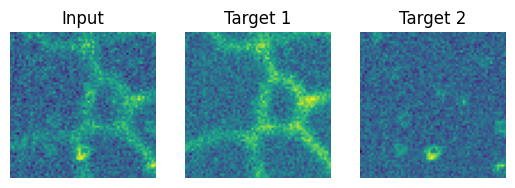

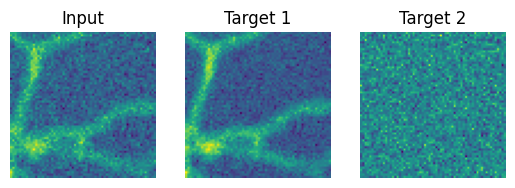

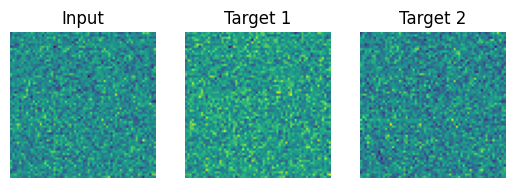

In [5]:
def plot_sample(sample):
    input, target = sample
    plt.subplot(1, 3, 1)
    plt.title('Input')
    plt.axis('off')
    plt.imshow(input[0])

    plt.subplot(1, 3, 2)
    plt.title('Target 1')
    plt.axis('off')
    plt.imshow(target[0])

    plt.subplot(1, 3, 3)
    plt.title('Target 2')
    plt.axis('off')
    plt.imshow(target[1])
    
    plt.show()
    
for index in range(3):
    sample = train_dset[index]
    plot_sample(sample)